In [1]:
import math
import torch
from torch import nn
from torch.nn import functional as F
from d2l import torch as d2l

In [2]:
class RNNScratch(d2l.Module):  #@save
    """The RNN model implemented from scratch."""
    def __init__(self, num_inputs, num_hiddens, sigma=0.01):
        super().__init__()
        self.save_hyperparameters()
        self.W_xh = nn.Parameter(
            torch.randn(num_inputs, num_hiddens) * sigma)
        self.W_hh = nn.Parameter(
            torch.randn(num_hiddens, num_hiddens) * sigma)
        self.b_h = nn.Parameter(torch.zeros(num_hiddens))

In [3]:
@d2l.add_to_class(RNNScratch)  #@save
def forward(self, inputs, state=None):
    if state is None:
        # Initial state with shape: (batch_size, num_hiddens)
        state = torch.zeros((inputs.shape[1], self.num_hiddens),
                          device=inputs.device)
    else:
        state, = state
    outputs = []
    for X in inputs:  # Shape of inputs: (num_steps, batch_size, num_inputs)
        state = torch.tanh(torch.matmul(X, self.W_xh) +
                         torch.matmul(state, self.W_hh) + self.b_h)
        outputs.append(state)
    return outputs, state

In [4]:
def check_len(a, n):  #@save
    """Check the length of a list."""
    assert len(a) == n, f'list\'s length {len(a)} != expected length {n}'

def check_shape(a, shape):  #@save
    """Check the shape of a tensor."""
    assert a.shape == shape, \
            f'tensor\'s shape {a.shape} != expected shape {shape}'

In [5]:
class EmbRNNLMScratch(d2l.Classifier):  #@save
    """The RNN-based language model implemented from scratch."""
    def __init__(self, rnn, vocab_size, lr=0.01, plot_flag=True, emb_len=8):
        super().__init__()
        self.save_hyperparameters()
        self.init_params()

    def init_params(self):
        self.W_hq = nn.Parameter(
            torch.randn(
                self.rnn.num_hiddens, self.emb_len) * self.rnn.sigma)
        self.b_q = nn.Parameter(torch.zeros(self.emb_len))
        self.lembs = nn.Parameter(torch.randn(self.vocab_size, self.emb_len))

    def forward(self, X, state=None):
        embs = torch.matmul(self.one_hot(X).float(),self.lembs)
        rnn_outputs, _ = self.rnn(embs, state)
        return self.output_layer(rnn_outputs)
    
    def training_step(self, batch, plot_flag=True):
        l = self.loss(self(*batch[:-1]), batch[-1])
        if plot_flag:
            self.plot('ppl', torch.exp(l), train=True)
        return l

    def validation_step(self, batch, plot_flag=True):
        l = self.loss(self(*batch[:-1]), batch[-1])
        if plot_flag:
            self.plot('ppl', torch.exp(l), train=False)
        return l
        
    def one_hot(self, X):
        # Output shape: (num_steps, batch_size, vocab_size)
        return F.one_hot(X.T, self.vocab_size).type(torch.float32)
    
    def output_layer(self, rnn_outputs):
        outputs = [torch.matmul(H, self.W_hq) + self.b_q for H in rnn_outputs]
        return torch.stack(outputs, 1)

6.779764175415039

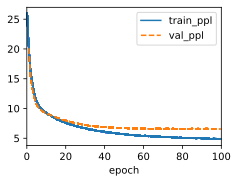

In [6]:
data = d2l.TimeMachine(batch_size=1024, num_steps=32)
emb_len=len(data.vocab)
rnn = RNNScratch(num_inputs=emb_len, num_hiddens=32)
model = EmbRNNLMScratch(rnn, vocab_size=len(data.vocab), lr=1, emb_len=emb_len)
trainer = d2l.Trainer(max_epochs=100, gradient_clip_val=1) #, num_gpus=1
trainer.fit(model, data)
X,y = next(iter(data.get_dataloader(False)))
y_hat = model(X) 
torch.exp(model.loss(y_hat,y)).item()